In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf

2024-03-27 16:38:47.123276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 16:38:47.123388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 16:38:47.289258: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='../input/cell-images-for-detecting-malaria/cell_images/cell_images/',
    validation_split=0.2,
    subset='training',
    shuffle = True,
    seed=111,
    image_size=(256, 256),
    batch_size=32)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='../input/cell-images-for-detecting-malaria/cell_images/cell_images/',
    validation_split=0.2,
    subset="validation",
    shuffle = True,
    seed=111,
    image_size=(256, 256),
    batch_size=32)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


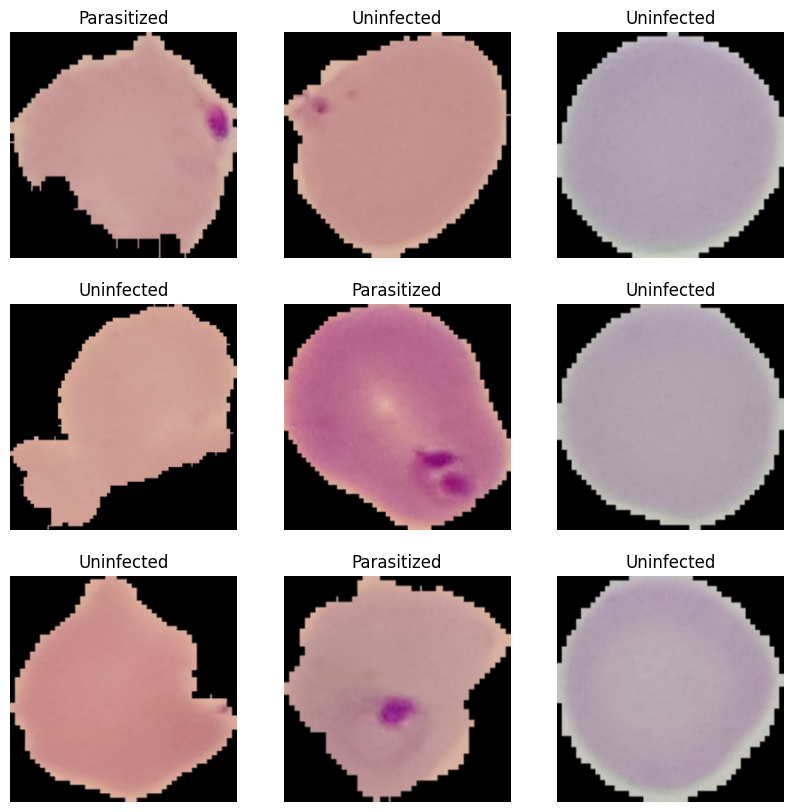

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Normalizing the image

In [8]:
from keras import layers

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8813925


## Model Building

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(256,256,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [14]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
epochs = 20
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs, callbacks = [early_stopping])

Epoch 1/20
  3/689 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.4983 - loss: 164.0268

I0000 00:00:1711557596.537946      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711557596.556887      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5455 - loss: 12.7749

W0000 00:00:1711557642.116349      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.5456 - loss: 12.7606 - val_accuracy: 0.7764 - val_loss: 0.5423
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6781 - loss: 0.5905 - val_accuracy: 0.8989 - val_loss: 0.4316
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.8817 - loss: 0.3561 - val_accuracy: 0.9476 - val_loss: 0.2438
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.9322 - loss: 0.2237 - val_accuracy: 0.9437 - val_loss: 0.2308
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9388 - loss: 0.2003 - val_accuracy: 0.9510 - val_loss: 0.1995
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.9441 - loss: 0.1822 - val_accuracy: 0.9541 - val_loss: 0.1849
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.9462 - loss: 0.1727 - val_accuracy: 0.9548 - val_loss: 0.1765
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.9451 - loss: 0.1721 - val_accura

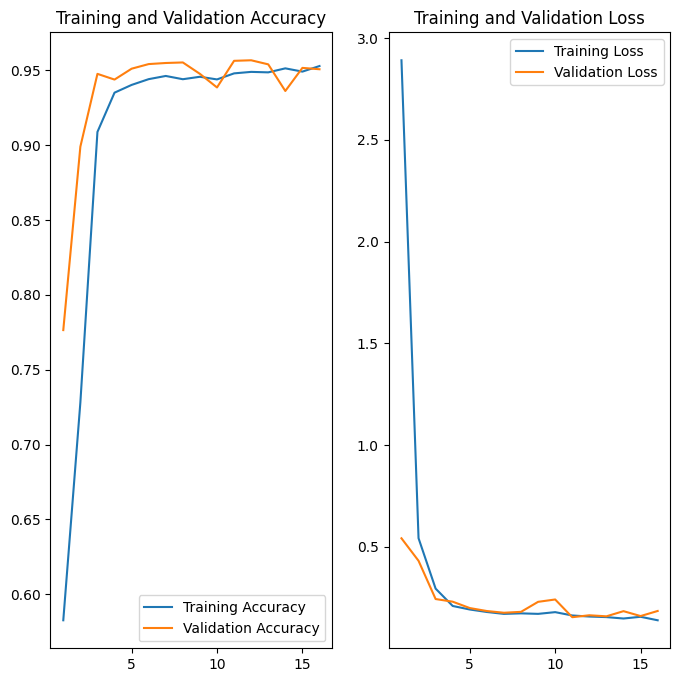

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()